In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
!pip install vnstock

In [3]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 15.2 MB/s eta 0:00:00


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import stumpy
import matplotlib.pyplot as plt
from datetime import datetime
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer, TorchNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss,CrossEntropy, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from vnstock import * #import all functions

# READ DATA

In [5]:
def convert_data_type(df, time_cols=[], float_cols = [], cat_cols = []):
    for col in time_cols:
        df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d')
    for col in float_cols:
        df[col] = df[col].astype(float)
    for col in cat_cols:
        df[col] = df[col].astype('category')
    return df

In [6]:
time_cols = ['time']
float_cols = ['open', 'high', 'low', 'close', 'volume']
cat_cols = ['ticker']

In [7]:
params = {
            "exchangeName": "HOSE",
            "marketCap": (10_000, 100_000),
            "industryName":"Retail"
        }


In [8]:
company_list = stock_screening_insights(params, size=1700, drop_lang='vi')['ticker'].tolist()
# company_list = company_list[:3] # Take first 3 companies to test

In [9]:
df = pd.DataFrame()
# Iterate over the company list and add the historical data for each company to the DataFrame
for company in company_list:
    df = pd.concat([df, stock_historical_data(company, "2020-01-01", "2023-06-30", "1D", "stock")], axis=0)

# Print the head of the DataFrame
df = convert_data_type(df, time_cols, float_cols, cat_cols)
df.head()

,time,open,high,low,close,volume,ticker
0,2020-01-02,11570.0,11990.0,11570.0,11990.0,45800.0,FRT
1,2020-01-03,11870.0,12780.0,11870.0,12480.0,25600.0,FRT
2,2020-01-06,12480.0,12480.0,11990.0,12090.0,53810.0,FRT
3,2020-01-07,12180.0,12180.0,11990.0,12040.0,39120.0,FRT
4,2020-01-08,12040.0,12040.0,11680.0,11710.0,54500.0,FRT


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1746 entries, 0 to 872
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1746 non-null   datetime64[ns]
 1   open    1746 non-null   float64       
 2   high    1746 non-null   float64       
 3   low     1746 non-null   float64       
 4   close   1746 non-null   float64       
 5   volume  1746 non-null   float64       
 6   ticker  1746 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(5)
memory usage: 97.3 KB


# CREATE DATASET

In [11]:
df = df.set_index('time', drop=True).reset_index() # Error data must have unique index

In [12]:
# Group by 'stock' and sort values by 'time'
df = df.groupby('ticker').apply(lambda x: x.sort_values('time')).reset_index(drop=True)

# Create 'time_idx' column from 0 to the length of each stock
df['time_idx'] = df.groupby('ticker').cumcount()

In [13]:
df.head()

,time,open,high,low,close,volume,ticker,time_idx
0,2020-01-02,11570.0,11990.0,11570.0,11990.0,45800.0,FRT,0
1,2020-01-03,11870.0,12780.0,11870.0,12480.0,25600.0,FRT,1
2,2020-01-06,12480.0,12480.0,11990.0,12090.0,53810.0,FRT,2
3,2020-01-07,12180.0,12180.0,11990.0,12040.0,39120.0,FRT,3
4,2020-01-08,12040.0,12040.0,11680.0,11710.0,54500.0,FRT,4


In [14]:
max_prediction_length = 4
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

In [15]:
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    group_ids=["ticker"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["ticker"],
#     static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
#     time_varying_known_categoricals=["special_days", "month"],
#     variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'open', 'high', 'low', 'close', 'volume',
    ],
    target_normalizer=GroupNormalizer(
        groups=["ticker"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=False,
    randomize_length = True, 
)

In [16]:
x, y = next(iter(training.to_dataloader(batch_size=4)))
print ('y',y[0])

y tensor([[17200., 17480., 17340., 17450.],
        [47730., 47380., 46550., 46650.],
        [27280., 27730., 27510., 27540.],
        [15360., 15470., 14840., 15080.]])


In [17]:
training.get_parameters

<bound method TimeSeriesDataSet.get_parameters of TimeSeriesDataSet[length=1744](
	time_idx='time_idx',
	target='close',
	group_ids=['ticker'],
	weight=None,
	max_encoder_length=24,
	min_encoder_length=12,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=4,
	static_categoricals=['ticker'],
	static_reals=['encoder_length', 'close_center', 'close_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['open', 'high', 'low', 'close', 'volume'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['ticker'],
	center=True,
	scale_by_group=False,
	transformation='softplus',
	method_kwargs={}
),
	categorical_encoders={'__group_id__ticker': NaNLabelEncoder(add_nan=False, war

In [18]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [19]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42


Number of parameters in network: 8.6k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 0.2454708915685031


suggested learning rate: 0.2454708915685031


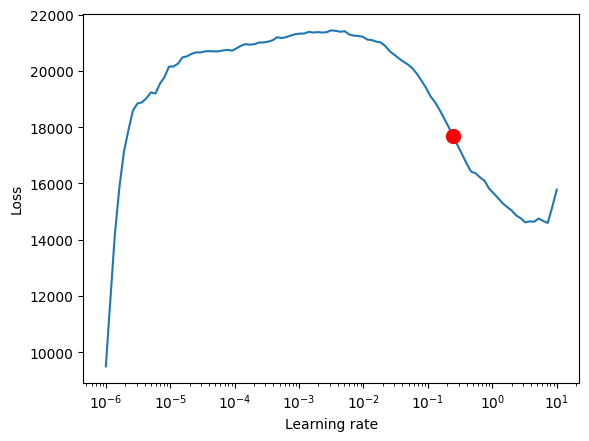

In [20]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [21]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 21.3k


In [22]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_init

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [23]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(1145.9272)

In [25]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


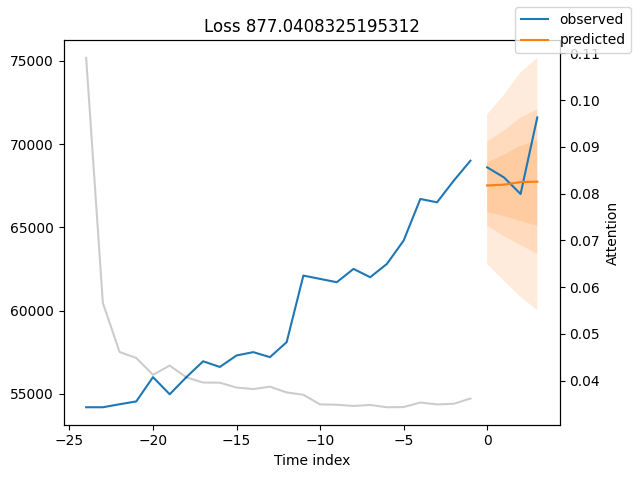

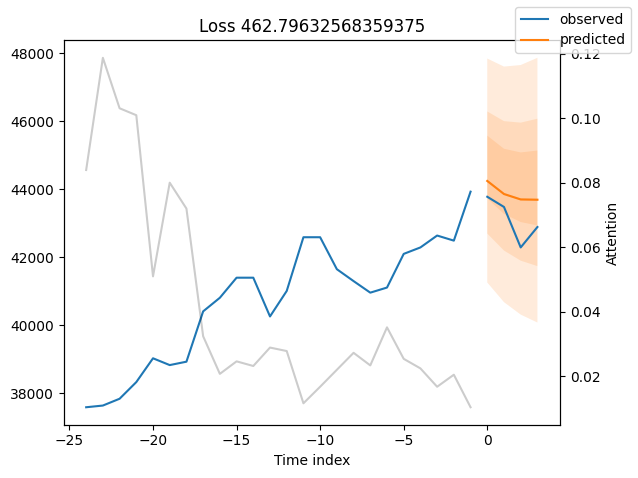

In [27]:
for idx in range(2):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

## Worst performers

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


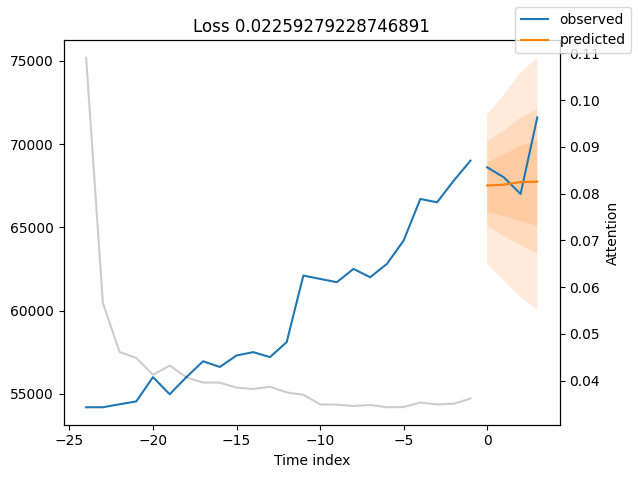

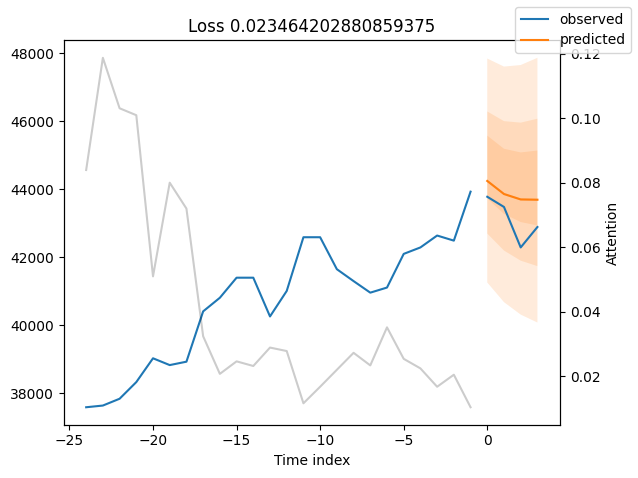

In [29]:
# calcualte metric by which to display
predictions = tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(2):  # plot 10 examples
    tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=tft.loss.quantiles),
    )

## Test

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


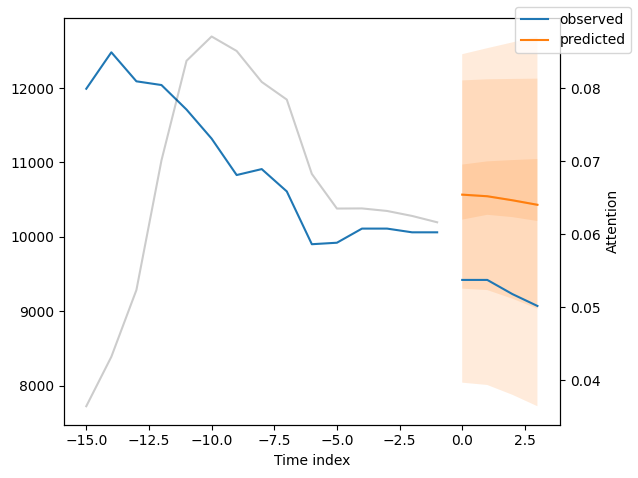

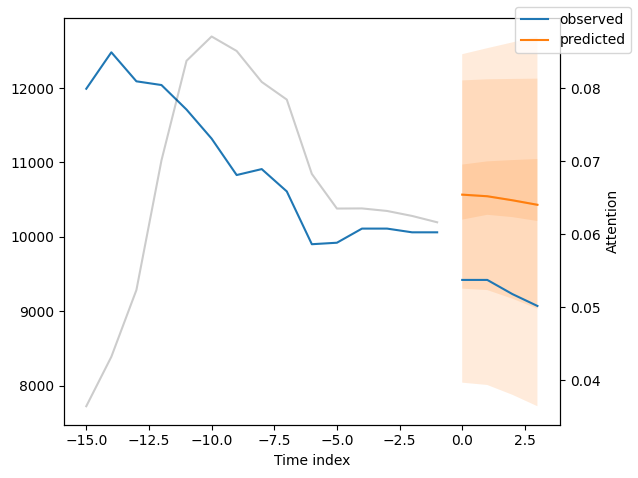

In [30]:
raw_prediction = tft.predict(
    training.filter(lambda x: (x.ticker == "FRT") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [38]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [41]:
import pickle

with open("/kaggle/working/tft.pkl",'wb') as f:
    pickle.dump(best_tft, f)

In [45]:
with open("/kaggle/input/test-model-tft/tft.pkl",'rb') as f:
    model=pickle.load(f)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


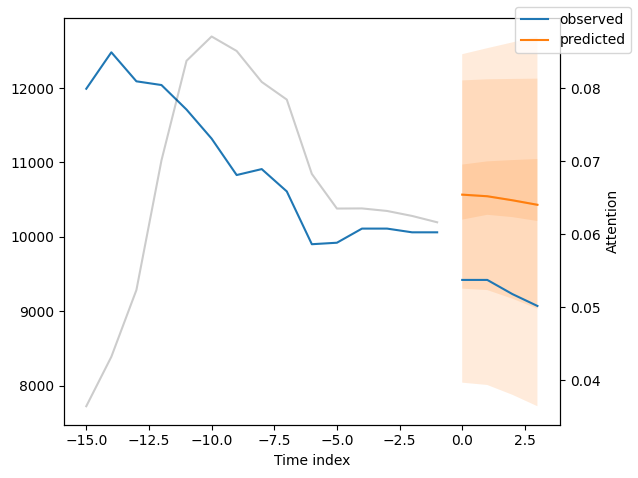

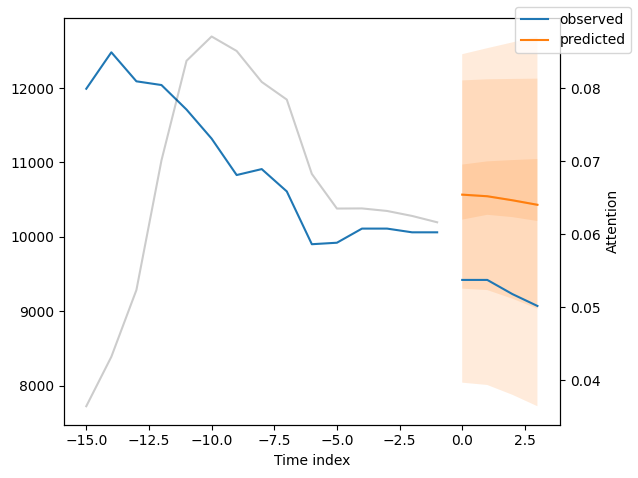

In [46]:
raw_prediction = model.predict(
    training.filter(lambda x: (x.ticker == "FRT") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
model.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)